In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../data/cvrp-instances-1.0/train/train_set.csv")

In [3]:
df.shape

(620, 163)

In [4]:
df.columns

Index(['distance_mean', 'distance_std', 'distance_median', 'distance_max',
       'distance_min', 'distance_var', 'media_moradores_por_domicilio_median',
       'media_moradores_por_domicilio_mean',
       'media_moradores_por_domicilio_std',
       'media_moradores_por_domicilio_var',
       ...
       'variancia_moradores_por_domicilio_var',
       'variancia_moradores_por_domicilio_min',
       'variancia_moradores_por_domicilio_max', 'target', 'demand_mean',
       'demand_std', 'demand_median', 'demand_max', 'demand_min',
       'demand_var'],
      dtype='object', length=163)

In [5]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.model_selection import train_test_split

In [6]:
Y = df["target"].copy()
X = df.drop(["target"], axis=1)
    
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values.tolist(), test_size=0.2, random_state=42)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame) -> pd.DataFrame:

    models = [("linear", LinearRegression()), 
            ("decision-tree", DecisionTreeRegressor(random_state = 0)), 
            ("random-forest", RandomForestRegressor(n_estimators = 10, random_state = 0)), 
            ("xgb", XGBRegressor(random_state=42))]

    dfs = []
    results = []
    names = []

    scoring = {'MSE': 'neg_mean_squared_error', 'R2': 'r2', 'MAPE': 'neg_mean_absolute_percentage_error', 'MSLE': 'neg_mean_squared_log_error', 'RSME': 'neg_root_mean_squared_error'}

    for name, model in models:
        print(name)
        kfold = model_selection.RepeatedKFold(n_splits=10, n_repeats=30, random_state=42)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
                
        results.append(cv_results)
            
        names.append(name)
        metrics = pd.DataFrame(cv_results)
        metrics['model'] = name
        dfs.append(metrics)
            
    final = pd.concat(dfs, ignore_index=True)
    return final

In [69]:
final = run_exps(X_train, y_train)

linear
decision-tree
random-forest
xgb


In [70]:
final

,fit_time,score_time,test_MSE,test_R2,test_MAPE,test_MSLE,test_RSME,model
0,0.008137,0.001255,-5.369846e+07,-0.188466,-0.089723,-0.012186,-7327.923191,linear
1,0.014289,0.001754,-3.371587e+07,0.134747,-0.075247,-0.008533,-5806.537224,linear
2,0.025771,0.001582,-4.854897e+07,-0.029964,-0.090050,-0.011866,-6967.709274,linear
3,0.010505,0.001563,-3.735861e+07,-0.161702,-0.077297,-0.008601,-6112.168971,linear
4,0.053479,0.001528,-5.588520e+07,-0.209077,-0.086859,-0.012986,-7475.640600,linear
...,...,...,...,...,...,...,...,...
1195,1.030892,0.006277,-4.413680e+07,-0.109398,-0.088045,-0.011207,-6643.552990,xgb
1196,1.833246,0.009054,-2.865846e+07,-0.039035,-0.067535,-0.006905,-5353.359598,xgb
1197,0.973605,0.007369,-4.244172e+07,0.228259,-0.079586,-0.010032,-6514.731255,xgb
1198,1.056664,0.013667,-4.166471e+07,0.127045,-0.075433,-0.009987,-6454.820696,xgb


In [80]:
results = pd.melt(final, id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time']

results_perf = results.loc[~results['metrics'].isin(time_metrics)]
results_perf = results_perf.sort_values(by='values')

results_time = results.loc[results['metrics'].isin(time_metrics)]
results_time = results_time.sort_values(by='values')

Text(0.5, 1.0, 'MAPE and MSLE for each model')

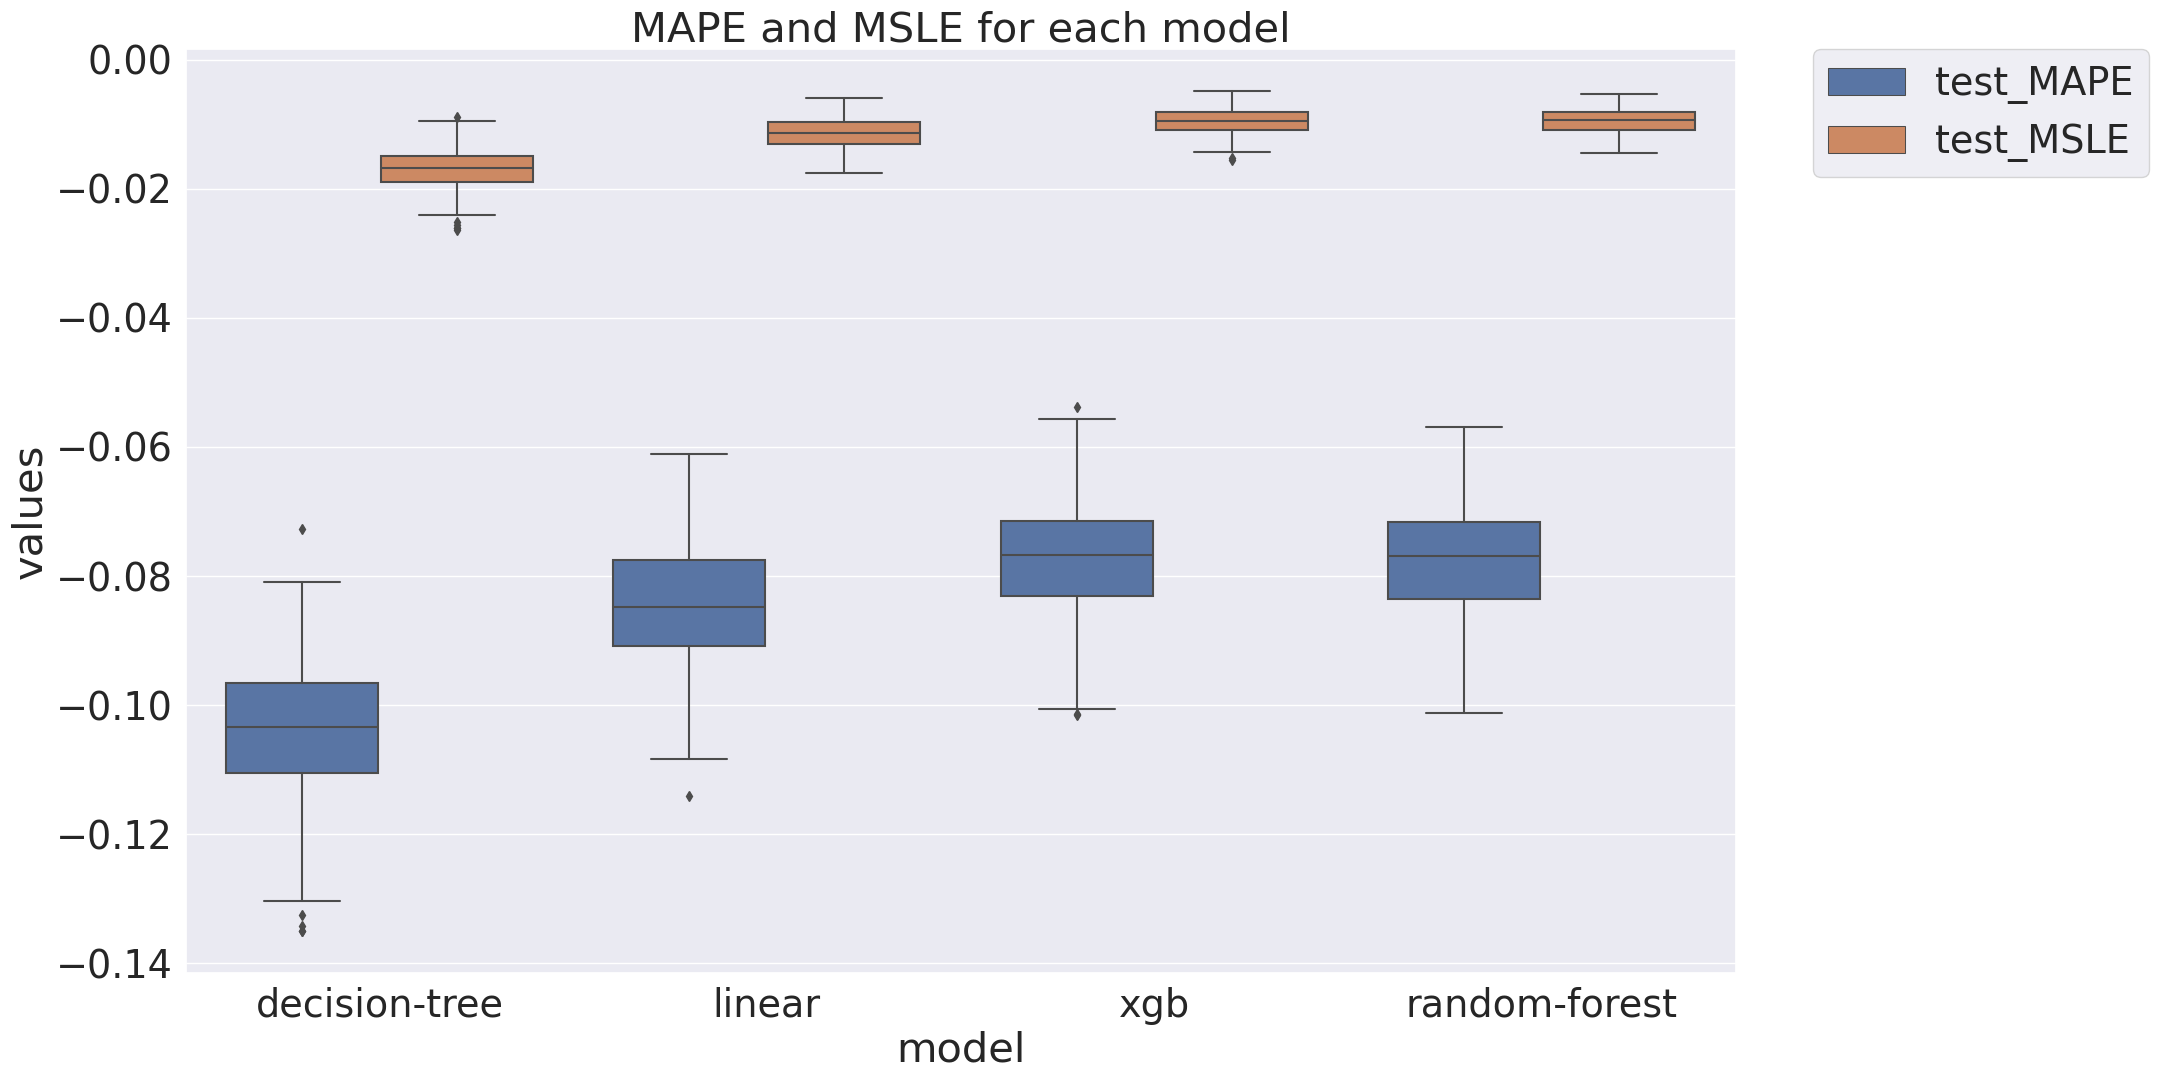

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_perf[results_perf["metrics"].isin(['test_MAPE', 'test_MSLE'])])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('MAPE and MSLE for each model')

Text(0.5, 1.0, 'RMSE for each model')

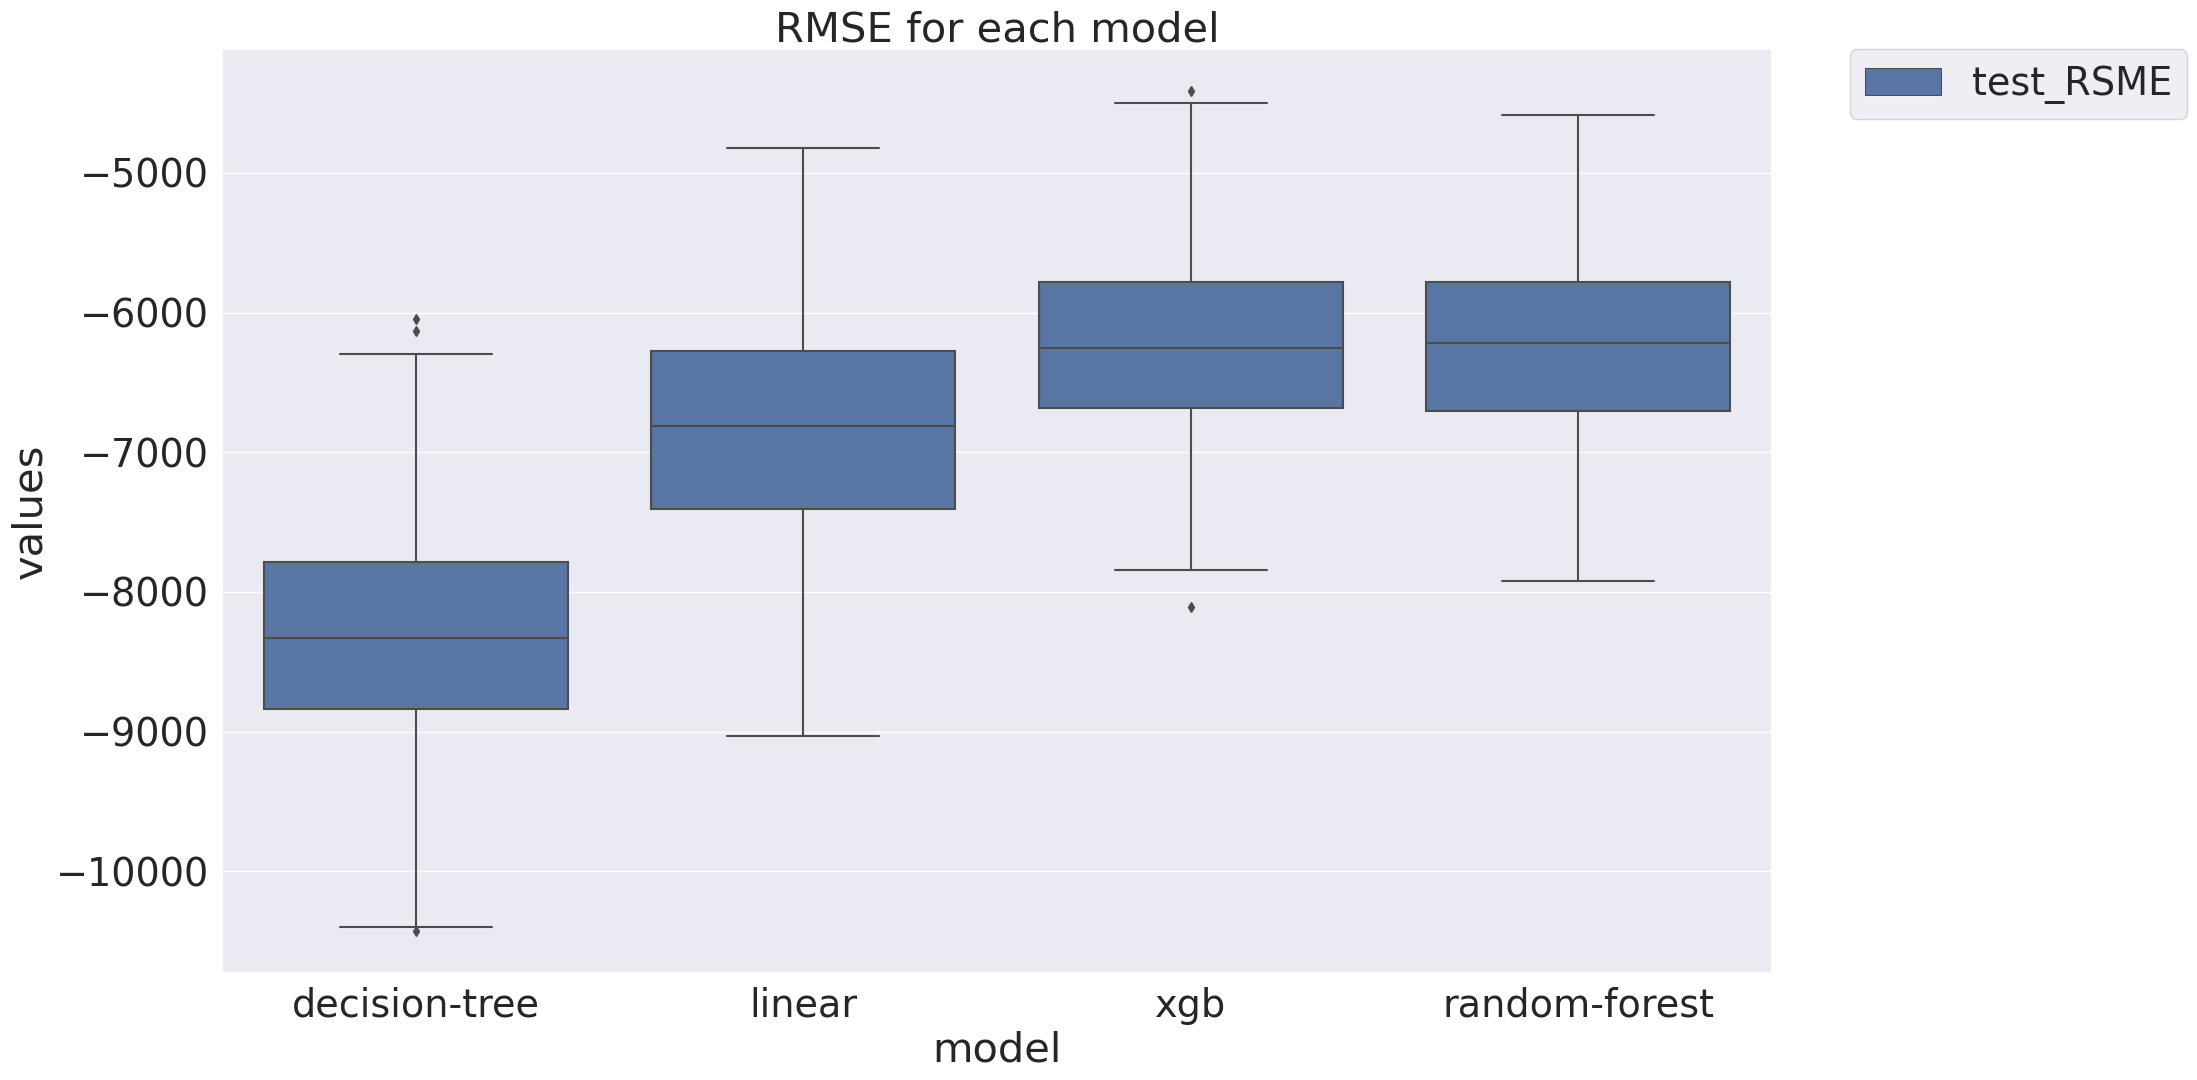

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_perf[results_perf["metrics"].isin(['test_RSME'])])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('RMSE for each model')

Text(0.5, 1.0, 'R2 for each model')

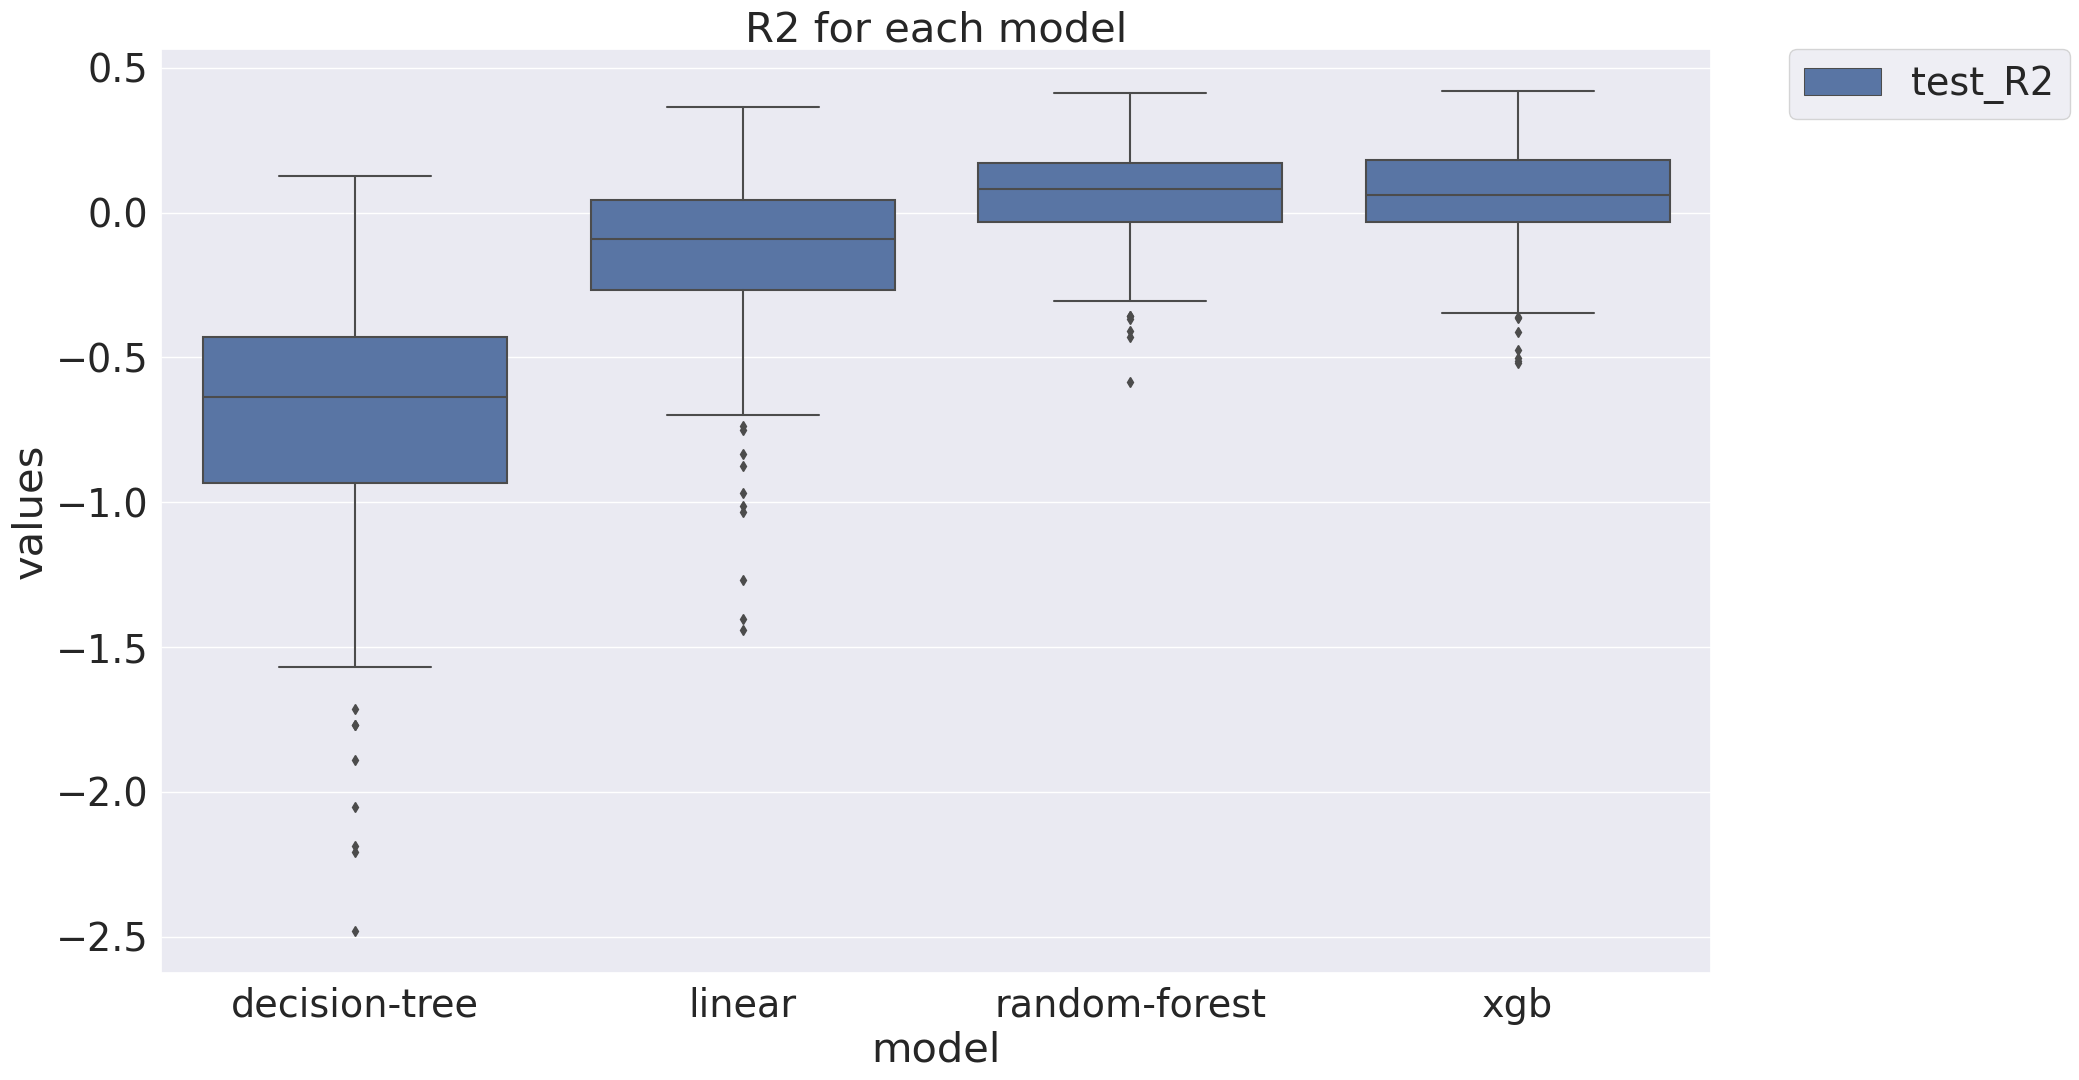

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_perf[results_perf["metrics"].isin(['test_R2'])])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('R2 for each model')

In [91]:
xgb = XGBRegressor(random_state=42)
params = {'n_estimators': [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            'max_depth': [10, 20, 30, 40, 50],
            'min_child_weight': [5, 10, 15, 20],
            'learning_rate': [0.01, 0.02],
            'subsample': [0.75],
            'colsample_bytree': [0.2, 0.3],
            'alpha': [0, 1, 2],
            'lambda': [0, 1, 10],
            'gamma': [2, 5, 10]
            }
xgb_cv = RandomizedSearchCV(xgb, param_distributions=params, scoring='r2', n_iter=20, cv=KFold(10, shuffle=True, random_state=42), random_state=42, verbose=1, n_jobs=-1)
xgb_cv.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=No...
                                          predictor=None, random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [0, 1, 2],
                                        'colsample_bytree': [0.2, 0.3],
                                        'gamma': [2, 5, 10],
                                        'lambda': [0, 1, 10],
                                        'learning_rate': [0.01, 0.02],
                                        'max_depth': [10, 20, 30, 40, 50],
                                        'min_child_weight': [5, 10, 15, 20],
                                        'n_estimators': [10, 20, 30, 40, 50,
                                                         100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'subsample': [0.75]},
                   random_state=42, scoring='r2', verbose=1)

In [92]:
xgb_cv.best_params_

{'subsample': 0.75,
 'n_estimators': 600,
 'min_child_weight': 10,
 'max_depth': 50,
 'learning_rate': 0.01,
 'lambda': 1,
 'gamma': 2,
 'colsample_bytree': 0.3,
 'alpha': 0}

In [9]:
xgb = XGBRegressor(subsample=0.75, n_estimators=600, min_child_weight=10, max_depth=50, learning_rate=0.01, gamma=2, colsample_bytree=0.3, alpha=0, random_state=42, eval_metric="rmse")
xgb.fit(X_train, y_train)

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [94]:
y_pred = xgb.predict(X_test)

In [96]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

y_pred = xgb.predict(X_train)
print(f"R2-Score train: {r2_score(y_train, y_pred)}\nMAPE train: {mean_absolute_percentage_error(y_train, y_pred)}")

y_pred = xgb.predict(X_test)
print(f"R2-Score test: {r2_score(y_test, y_pred)}\nMAPE test: {mean_absolute_percentage_error(y_test, y_pred)}")


R2-Score train: 0.9117669152303546
MAPE train: 0.021352795438894897
R2-Score test: 0.19902833975219225
MAPE test: 0.07671284280569876


In [10]:
import shap 

shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

/home/gegen07/anaconda3/envs/ds-comp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


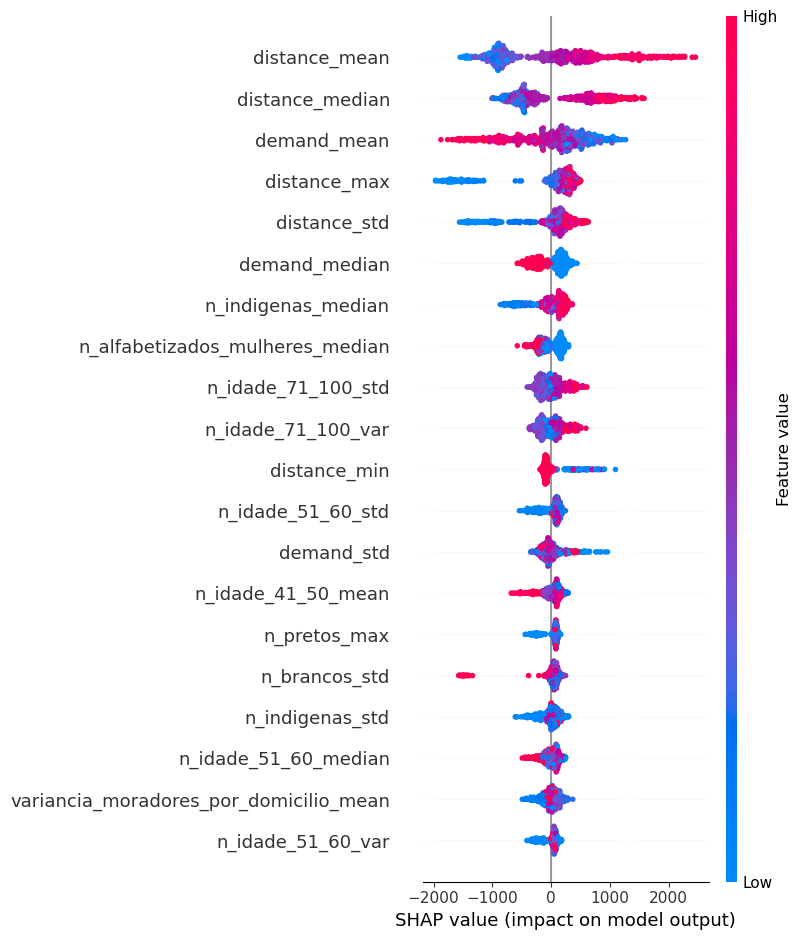

In [11]:
shap.summary_plot(shap_values, X)

In [97]:
import pickle
pickle.dump(xgb, open("cvrp-ml.model", "wb"))